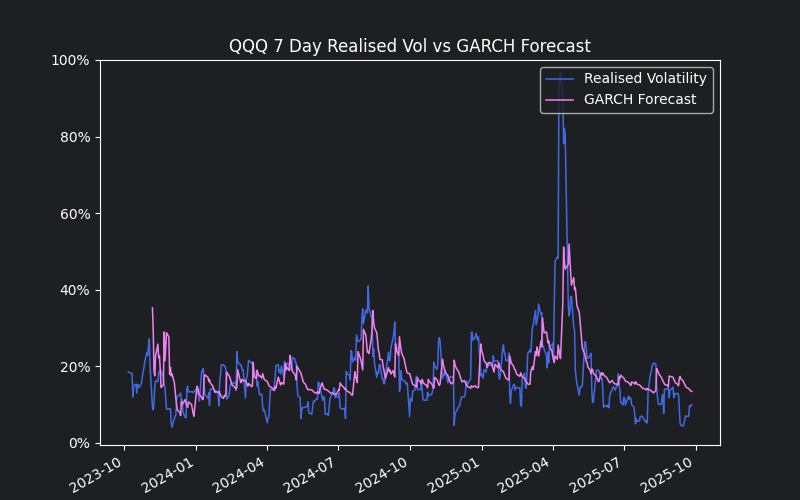

In [20]:
#30 DAY ANNUALISED

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from matplotlib import ticker
from arch.univariate import arch_model
%matplotlib widget
plt.rcParams.update({"axes.facecolor":"#1e1f22","figure.facecolor":"#1e1f22","axes.edgecolor":"#ffffff","text.color":"#ffffff"})

#SETUP
symbol = "QQQ"
period = 7
df = DataFrame(yf.Ticker(symbol).history(period = "2y")["Close"])
df["Return"] = np.log(df["Close"]/df["Close"].shift(1))
df["Realised Vol"] = df["Return"].rolling(period).std()*np.sqrt(252)

#GARCH
forecasts = {}
basic_gm = arch_model(df["Return"].iloc[1:]*100, p = 1, o = 1, q = 1, mean = "constant", vol = "GARCH", dist = "skewt")

for i in range(period*3,len(df["Return"])-period):
    res = basic_gm.fit(last_obs = i, disp = "off", options = {"maxiter": 200,"ftol": 1e-07})
    gm_forecast = res.forecast(horizon = period).variance.iloc[0,:].values/10000 #daily variances
    agg_vol = np.sqrt(gm_forecast.mean())*np.sqrt(252)
    forecasts[df.index[i+period]] = agg_vol
df["Forecast Vol"] = forecasts

#PLOT
fig, ax = plt.subplots()
ax.plot(df["Realised Vol"], "royalblue", linewidth = 1.1)
ax.plot(df["Forecast Vol"], "violet", linewidth = 1.1)
fig.legend(labels = ["Realised Volatility","GARCH Forecast"], bbox_to_anchor = (0.9,0.88))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ylim(top=np.ceil(max(df["Realised Vol"].dropna().max(), df["Forecast Vol"].dropna().max())*10)/10)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1, decimals = 0))
ax.format_xdata = mdates.DateFormatter("%Y-%m-%d").format_data
ax.set_title(f"{symbol} {period} Day Realised Vol vs GARCH Forecast")
fig.set_figwidth(8), fig.set_figheight(5)
fig.canvas.toolbar_visible = False
plt.show();

            Realised  Forecast Vol
2024-09-27  0.017048           NaN
2024-09-30  0.045294      0.005190
2024-10-01  0.091119      0.179823
2024-10-02  0.020552      0.040461
2024-10-03  0.038396      0.054685
2024-10-04  0.017421      0.046999
2024-10-07  0.018325      0.047276
2024-10-08  0.032904      0.064260
2024-10-09  0.015476      0.039444
2024-10-10  0.023126      0.038673
2024-10-11  0.040938      0.068394
2024-10-14  0.041024      0.042654
2024-10-15  0.016715      0.040619
2024-10-16  0.017800      0.038907
2024-10-17  0.025655      0.026087
2024-10-18  0.017021      0.024395
2024-10-21  0.039970      0.021930
2024-10-22  0.030653      0.031399
2024-10-23  0.040911      0.032285
2024-10-24  0.018597      0.037752
2024-10-25  0.064560      0.036299


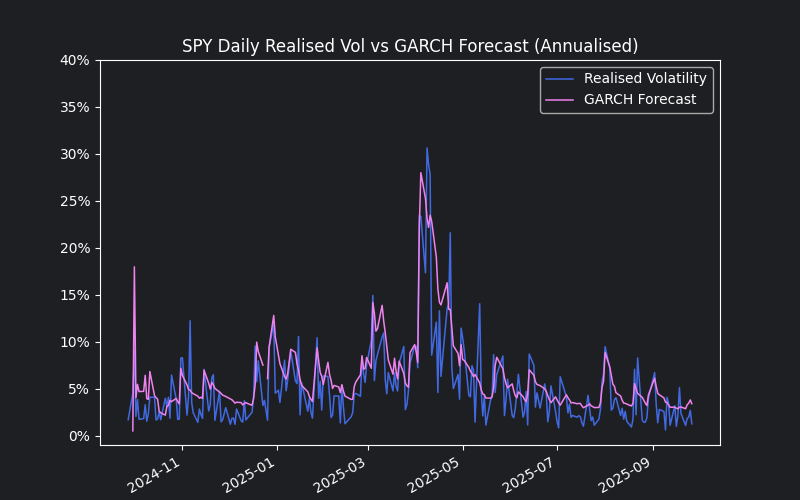

In [18]:
#DAILY ANNUALISED

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from matplotlib import ticker
import matplotlib.dates as mdates
from arch import arch_model

%matplotlib widget
plt.rcParams.update(
    {"axes.facecolor": "#1e1f22", "figure.facecolor": "#1e1f22", "axes.edgecolor": "#ffffff", "text.color": "#ffffff","xtick.color":"#ffffff","ytick.color":"#ffffff"})

#COLLECT
symbol = "SPY"
df = DataFrame(yf.Ticker(symbol).history(period="1y", interval = "1h")["Close"]) #seven 1hr periods per trading day
df["Return"] = np.log(df["Close"] / df["Close"].shift(1))
vols = DataFrame(index = np.unique(df.index.date))
vols["Realised"] = df["Return"].groupby(df.index.date).std()*np.sqrt(252)

#GARCH
forecasts = {}
basic_gm = arch_model(df["Return"].iloc[1:]*1000, p = 1, o = 1, q = 1, mean = "constant", vol = "GARCH", dist = "skewt")

for i in range(7,len(df["Return"])-1,7):
    res = basic_gm.fit(last_obs = i, disp = "off", options = {"maxiter": 200,"ftol": 1e-07})
    gm_forecast = res.forecast(horizon = 7).variance.iloc[0,:]
    agg_vol = np.sqrt((gm_forecast.values/1000000).mean())*np.sqrt(252)
    forecasts[gm_forecast.name.date()] = agg_vol

vols["Forecast Vol"] = forecasts

#PLOT
fig, ax = plt.subplots()
ax.plot(vols["Realised"], "royalblue", linewidth=1.1)
ax.plot(vols["Forecast Vol"], "violet", linewidth=1.1)
fig.legend(labels=["Realised Volatility", "GARCH Forecast"], bbox_to_anchor=(0.9, 0.88))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ylim(top=np.ceil(max(vols["Realised"].dropna().max(), vols["Forecast Vol"].dropna().max())*10)/10)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.format_xdata = mdates.DateFormatter("%Y-%m-%d").format_data
ax.set_title(f"{symbol} Daily Realised Vol vs GARCH Forecast (Annualised)")
fig.set_figwidth(8), fig.set_figheight(5)
fig.canvas.toolbar_visible = False
plt.show();